# YAASS, FAME, SCORE Datasets

## The dataset below includes demographic information and multiple clinical measures taken in 4 populations: healthy controls, those at clinical high risk for psychosis, those at familial high risk, and those diagnosed with schizophrenia.

In [1]:
# Get the username and use that to set-up paths to data and figures
uname  = !whoami
uname = uname[0]
path2code = '/Users/' + uname + '/Work/Dillon/Expts/Code/'
path2data = '/Users/' + uname + '/Work/Lincoln/Expts/YAASS/Data/Old/'
path2analysis = '/Users/' + uname + '/Work/Lincoln/Expts/YAASS/Analysis/'
path2figs = '/Users/' + uname + '/Work/Lincoln/Expts/YAASS/Analysis/Figures/'

In [73]:
%cd {path2code}

import csv, misc, os, random, re, SelfRep
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
from scipy import stats
from scipy.stats import zscore
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext rpy2.ipython

%R suppressMessages(library('lmerTest'))
%R suppressMessages(library('lsmeans'))
%R lsm.options(disable.pbkrtest=TRUE)
%R suppressMessages(library('effsize')) # Can use this to estimate Cohen's d
%R suppressMessages(library('afex'))
%R suppressMessages(library('QuantPsyc')) #helpful for extracting betas from hierarchical regresssions
%R suppressMessages(library('vcd')) # useful for getting effect sizes from chi-square tests

/Users/ebarrick/Work/Dillon/Expts/Code
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['vcd', 'grid', 'QuantPsyc', 'MASS', 'boot', 'afex', 'effsize',
       'lsmeans', 'estimability', 'lmerTest', 'lme4', 'Matrix', 'tools',
       'stats', 'graphics', 'grDevices', 'utils', 'datasets', 'methods',
       'base'],
      dtype='|S12')

### Building the dataframe

In [3]:
#Function to assign names to disorders column
# def dx_name(data):
#     d = {0:'None', 1:'MDD', 2:'Anxiety', 3:'Sub_abuse', 4:'ADHD', 
#          5:'Eating', 6:'Schizotypal', 7:'2_co', 8: '3_co', 9:'4_co','999':'na'}
#     dx = d[data]
#     return dx 

In [4]:
# """YAASS data: CHR and HC"""
# raw_chr = pd.read_excel(path2data + 'Bx_Paper_YAASS_Feb2017_edit.xlsx')
# raw_chr['Gender'].replace(2, 'female', inplace=True)
# raw_chr['Gender'].replace(1,'male', inplace=True)

# #individual IRI scores
# raw_iri_Y = pd.read_excel(path2data + 'YAASS_IRI.xlsx', sheetname='IRI_EB')
# raw_iri_Y = raw_iri_Y.rename(columns={"Subject": "ID"})

# #rescaling the IRI scores from the individual data
# new = {1: 1, 2: 1.8, 3: 2.6, 4: 3.4, 5: 4.2, 6: 5} 
# Y = raw_iri_Y.applymap(lambda d: new.get(d) if d in new else d)
# Y.reindex()

# #Getting the total for each IRI subscale
# fs = ['1_FS', '5_FS', '7_FS_R', '12_FS_R', '16_FS', '23_FS', '26_FS']
# ec = ['2_EC', '4_EC_R', '9_EC', '14_EC_R', '18_EC_R', '20_EC', '22_EC']
# pt = ['3_PT_R', '8_PT', '11_PT', '15_PT_R', '21_PT', '25_PT', '28_PT']
# pd = ['6_PD', '10_PD', '13_PD_R', '17_PD', '19_PD_R', '24_PD', '27_PD']

# Y['IRI_FS_total'] = Y[fs].sum(axis=1)
# Y['IRI_EC_total'] = Y[ec].sum(axis=1)
# Y['IRI_PT_total'] = Y[pt].sum(axis=1)
# Y['IRI_PD_total'] = Y[pd].sum(axis=1)

# Y = Y[['ID','IRI_FS_total','IRI_EC_total','IRI_PT_total','IRI_PD_total']].copy()

In [5]:
# merge new IRI scores with YAASS data
# y = raw_chr.merge(Y, on='ID', how='left')

In [6]:
# """SCORE data: SZ and HC"""
# raw_sz = pd.read_excel(path2data + 'SCORE Data_Bx_IRI_SocialFx.xlsx')
# raw_sz['Group'].replace(2, 'SZ', inplace=True)
# raw_sz['Group'].replace(1,'HC',inplace=True)
# raw_sz['Gender'].replace(1,'male',inplace=True)
# raw_sz['Gender'].replace(2,'female',inplace=True)

# #individual IRI scores
# raw_iri_S = pd.read_excel(path2data + 'IRI_DAS_CERQ_SCORE.xlsx', sheetname='IRI_EB')
# raw_iri_S = raw_iri_S.rename(columns={"Subject": "ID"})

# #rescaling the IRI scores from the individual data
# new = {1: 1, 2: 1.8, 3: 2.6, 4: 3.4, 5: 4.2, 6: 5} 
# S = raw_iri_S.applymap(lambda d: new.get(d) if d in new else d)
# S.reindex()

# #Getting the total for each IRI subscale
# fs = ['1_FS', '5_FS', '7_FS_R', '12_FS_R', '16_FS', '23_FS', '26_FS']
# ec = ['2_EC', '4_EC_R', '9_EC', '14_EC_R', '18_EC_R', '20_EC', '22_EC']
# pt = ['3_PT_R', '8_PT', '11_PT', '15_PT_R', '21_PT', '25_PT', '28_PT']
# pd = ['6_PD', '10_PD', '13_PD_R', '17_PD', '19_PD_R', '24_PD', '27_PD']

# S['IRI_FS_total'] = S[fs].sum(axis=1)
# S['IRI_EC_total'] = S[ec].sum(axis=1)
# S['IRI_PT_total'] = S[pt].sum(axis=1)
# S['IRI_PD_total'] = S[pd].sum(axis=1)

# S = S[['ID','IRI_FS_total','IRI_EC_total','IRI_PT_total','IRI_PD_total']].copy()

In [7]:
#merge new IRI scores with SCORE data
# s = raw_sz.merge(, on='ID', how='left')

In [8]:
# """FAME data: FHR"""

# raw_fhr = pd.read_excel(path2data + 'FAME_Neuropsych_NEW_edit.xlsx')
# raw_fhr['Group'].replace(1, 'FHR', inplace=True)
# raw_fhr['Gender'].replace(2, 'female', inplace=True)
# raw_fhr['Gender'].replace(1,'male', inplace=True)
# raw_fhr = raw_fhr.rename(columns={"IRI_PT": "IRI_PT_total", "IRI_EC": "IRI_EC_total", "IRI_PD": "IRI_PD_total", 
#                                   "IRI_FS": "IRI_FS_total"})

In [9]:
# g = pd.concat([raw_fhr, s])

In [10]:
# raw = pd.concat([g,y])
# pd.set_option('display.max_columns', 500)
# raw.tail()

In [11]:
# output to csv
# raw.to_csv('raw.csv')

In [13]:
raw = pd.read_csv(path2data + 'raw.csv')

In [14]:
raw.head()

,ID,Group,Gender,Age,Education,Ethnicity,IQ,DSMDisorder,DSMDisorderType,DSMcomorbidities,...,PANAS_PA,SIPS_Disorganized,SIPS_General,SIPS_Negative,SIPS_Positive,SocAdjScale_SocialLeisure,SocAdjScale_Work,GFS_Role,GFS_Social,Present_Clinical
0,2501,FHR,female,25,14.0,NaN,99.0,1.0,7.0,2.0,...,NaN,0.75,0.75,0.500000,1.4,NaN,NaN,NaN,NaN,1.0
1,2504,FHR,female,29,16.0,NaN,118.0,1.0,7.0,2.0,...,NaN,0.50,0.50,0.333333,1.0,38.0,51.0,NaN,NaN,1.0
2,2505,FHR,male,33,14.0,NaN,95.0,0.0,0.0,0.0,...,NaN,0.25,0.00,0.000000,0.4,51.0,58.0,NaN,NaN,0.0
3,2506,FHR,male,33,13.0,NaN,109.0,1.0,4.0,1.0,...,NaN,1.00,0.75,1.166667,1.2,49.0,55.0,NaN,NaN,1.0
4,2508,FHR,male,28,16.0,NaN,118.0,0.0,NaN,0.0,...,NaN,1.25,1.00,0.500000,1.4,40.0,64.0,NaN,NaN,0.0


In [15]:
raw['sx_group']=raw.Group.copy()
raw['sx_group'].replace('HC', 1, inplace=True)
raw['sx_group'].replace('FHR', 1, inplace=True)
raw['sx_group'].replace('CHR', 2, inplace=True)
raw['sx_group'].replace('SZ', 2, inplace=True)

In [16]:
raw.head()

,ID,Group,Gender,Age,Education,Ethnicity,IQ,DSMDisorder,DSMDisorderType,DSMcomorbidities,...,SIPS_Disorganized,SIPS_General,SIPS_Negative,SIPS_Positive,SocAdjScale_SocialLeisure,SocAdjScale_Work,GFS_Role,GFS_Social,Present_Clinical,sx_group
0,2501,FHR,female,25,14.0,NaN,99.0,1.0,7.0,2.0,...,0.75,0.75,0.500000,1.4,NaN,NaN,NaN,NaN,1.0,1
1,2504,FHR,female,29,16.0,NaN,118.0,1.0,7.0,2.0,...,0.50,0.50,0.333333,1.0,38.0,51.0,NaN,NaN,1.0,1
2,2505,FHR,male,33,14.0,NaN,95.0,0.0,0.0,0.0,...,0.25,0.00,0.000000,0.4,51.0,58.0,NaN,NaN,0.0,1
3,2506,FHR,male,33,13.0,NaN,109.0,1.0,4.0,1.0,...,1.00,0.75,1.166667,1.2,49.0,55.0,NaN,NaN,1.0,1
4,2508,FHR,male,28,16.0,NaN,118.0,0.0,NaN,0.0,...,1.25,1.00,0.500000,1.4,40.0,64.0,NaN,NaN,0.0,1


In [30]:
%Rpush raw
%R str(raw)

'data.frame':	110 obs. of  32 variables:
 $ ID                       : int  2501 2504 2505 2506 2508 2509 2510 2511 2513 2515 ...
 $ Group                    : Factor w/ 4 levels "CHR","FHR","HC",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Gender                   : Factor w/ 2 levels "female","male": 1 1 2 2 2 1 1 1 1 1 ...
 $ Age                      : int  25 29 33 33 28 25 30 32 27 27 ...
 $ Education                : num  14 16 14 13 16 17 18 15 19 16 ...
 $ Ethnicity                : num  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
 $ IQ                       : num  99 118 95 109 118 121 123 128 122 118 ...
 $ DSMDisorder              : num  1 1 0 1 0 1 1 1 1 1 ...
 $ DSMDisorderType          : num  7 7 0 4 NaN 2 8 7 7 8 ...
 $ DSMcomorbidities         : num  2 2 0 1 0 1 3 2 2 3 ...
 $ IRI_EC_total             : num  NaN 21 21 14 18 26 22 16 20 25 ...
 $ IRI_FS_total             : num  NaN 6 19 15 16 18 16 17 10 18 ...
 $ IRI_PD_total             : num  NaN 6 5 9 16 11 8 13 8 11 ...
 $ IRI_PT

# Demographics

In [31]:
print ('Total Group Count')
raw.groupby('Group')['ID'].nunique()

Total Group Count


Group
CHR    27
FHR    19
HC     38
SZ     26
Name: ID, dtype: int64

In [32]:
#more males in all groups except FHR

print ('Gender by Group')
raw.groupby('Group')['Gender'].value_counts()

Gender by Group


Group  Gender
CHR    male      18
       female     9
FHR    female    14
       male       5
HC     male      22
       female    16
SZ     male      16
       female    10
Name: Gender, dtype: int64

Age by Group
       count       mean        std   min    25%   50%    75%   max
Group                                                             
CHR     27.0  21.629630   4.404090  15.0  18.00  22.0  23.50  34.0
FHR     19.0  27.421053   3.920258  20.0  24.50  27.0  31.00  33.0
HC      38.0  29.763158  11.769025  18.0  21.00  24.0  41.50  55.0
SZ      26.0  38.692308  10.279180  21.0  31.25  38.5  44.75  58.0


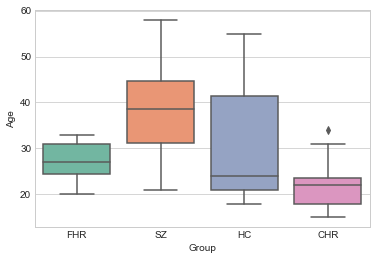

In [33]:
print ('Age by Group')
g=raw.groupby('Group')
print (g.Age.describe())

sns.set_context(font_scale=2.5)
sns.set_palette("Set2")
sns.set_style("whitegrid")

sns.boxplot(x='Group',y='Age',data=raw)

In [34]:
"""Dataframe dropping participants without an IQ value"""
raw_IQ = raw[np.isfinite(raw['IQ'])]

Group
CHR    106.791667
FHR    117.000000
HC     112.105263
SZ     108.076923
Name: IQ, dtype: float64
Group
CHR    17.688068
FHR     9.779931
HC     11.668367
SZ     13.323432
Name: IQ, dtype: float64
ANOVA for IQ x Group


             Df Sum Sq Mean Sq F value Pr(>F)  
Group         3   1335   444.9    2.48 0.0653 .
Residuals   102  18297   179.4                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


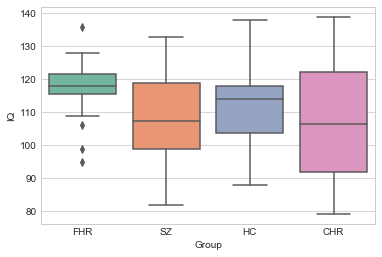

In [35]:
i = raw_IQ.groupby('Group')

print (i.IQ.mean())
print (i.IQ.std())

sns.boxplot(x='Group',y='IQ',data=raw_IQ)

sns.set_context(font_scale=2.5)
sns.set_palette("Set2")
sns.set_style("whitegrid")

%Rpush raw_IQ
print ('ANOVA for IQ x Group')
%R iq2.aov <- aov(IQ ~ Group, data=raw_IQ)
%R print (summary(iq2.aov))

# Looking at Measures

## IRI

IRI_EC Mean
Group
CHR    22.338462
FHR    20.333333
HC     25.589474
SZ     24.853846
Name: IRI_EC_total, dtype: float64
IRI_FS Mean
Group
CHR    22.153846
FHR    15.166667
HC     19.568421
SZ     22.453846
Name: IRI_FS_total, dtype: float64
IRI_PD Mean
Group
CHR    17.784615
FHR     8.833333
HC     13.589474
SZ     16.053846
Name: IRI_PD_total, dtype: float64
IRI_PT Mean
Group
CHR    21.807692
FHR    21.500000
HC     24.978947
SZ     24.453846
Name: IRI_PT_total, dtype: float64


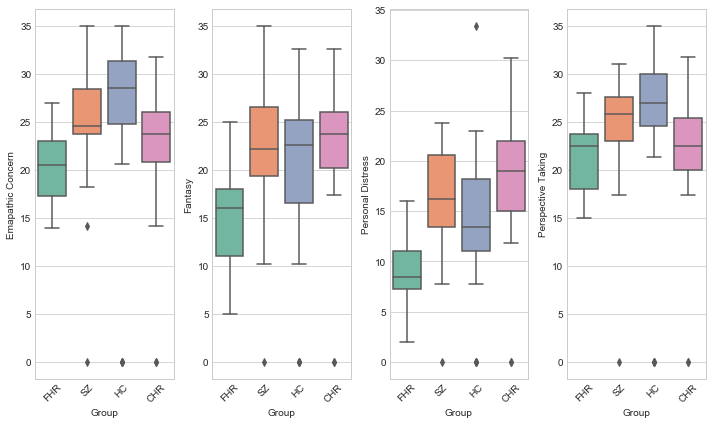

In [36]:
#SCORE and YAASS scored on 6-pt scale, FAME on 5-pt scale. Re-scaled the SCORE and YAASS data above.

print('IRI_EC Mean')
print(g.IRI_EC_total.mean())
print('IRI_FS Mean')
print(g.IRI_FS_total.mean())
print('IRI_PD Mean')
print(g.IRI_PD_total.mean())
print('IRI_PT Mean')
print(g.IRI_PT_total.mean())

sns.set_context(font_scale=2.5)
sns.set_palette("Set2")
sns.set_style("whitegrid")

fig = plt.figure(figsize=(10, 6))
iri = fig.add_subplot(141)
sns.boxplot(y='IRI_EC_total', x='Group', data = raw)
plt.ylabel('Emapathic Concern')
plt.xticks(rotation=45)

iri = fig.add_subplot(142)
sns.boxplot(y='IRI_FS_total', x='Group', data = raw)
plt.ylabel('Fantasy')
plt.xticks(rotation=45)

iri = fig.add_subplot(143)
sns.boxplot(y='IRI_PD_total', x='Group', data = raw)
plt.ylabel('Personal Distress')
plt.xticks(rotation=45)

iri = fig.add_subplot(144)
sns.boxplot(y='IRI_PT_total', x='Group', data = raw)
plt.ylabel('Perspective Taking')
plt.xticks(rotation=45)
fig.tight_layout()

# sns.plt.savefig(path2figs + 'IRI.pdf')

In [37]:
print ('ANOVA on Empathic concern x Group')
%R ec.aov <- aov(IRI_EC_total ~ Group, data=raw)
%R print (summary(ec.aov))

print ('ANOVA on Fantasy x Group')
%R fs.aov <- aov(IRI_FS_total ~ Group, data=raw)
%R print (summary(fs.aov))

print ('ANOVA on Personal Distress x Group')
%R pd.aov <- aov(IRI_PD_total ~ Group, data=raw)
%R print (summary(pd.aov))

print ('ANOVA on Perspective Taking x Group')
%R pt.aov <- aov(IRI_PT_total ~ Group, data=raw)
%R print (summary(pt.aov))

ANOVA on Empathic concern x Group


             Df Sum Sq Mean Sq F value Pr(>F)  
Group         3    422  140.73   2.306 0.0811 .
Residuals   104   6348   61.04                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
2 observations deleted due to missingness


ANOVA on Fantasy x Group


             Df Sum Sq Mean Sq F value  Pr(>F)   
Group         3    702  234.09   4.094 0.00862 **
Residuals   104   5946   57.17                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
2 observations deleted due to missingness


ANOVA on Personal Distress x Group


             Df Sum Sq Mean Sq F value   Pr(>F)    
Group         3    952   317.2   8.372 4.89e-05 ***
Residuals   104   3941    37.9                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
2 observations deleted due to missingness


ANOVA on Perspective Taking x Group


             Df Sum Sq Mean Sq F value Pr(>F)
Group         3    253   84.41   1.514  0.215
Residuals   104   5798   55.75               
2 observations deleted due to missingness


In [38]:
print ('Followup on Fantasy x Group')
%R fs.lsm <- lsmeans(fs.aov, ~ Group, adjust='tukey')
%R print(fs.lsm)
%R print(pairs(fs.lsm))

print ('Followup on Personal Distress x Group')
%R pd.lsm <- lsmeans(pd.aov, ~ Group, adjust='tukey')
%R print(pd.lsm)
%R print(pairs(pd.lsm))

print ('Followup on Empathic Concern x Group - trend')
%R ec.lsm <- lsmeans(ec.aov, ~ Group, adjust='tukey')
%R print(ec.lsm)
%R print(pairs(ec.lsm))

Followup on Fantasy x Group


 Group   lsmean       SE  df lower.CL upper.CL
 CHR   22.15385 1.482877 104 19.21325 25.09445
 FHR   15.16667 1.782196 104 11.63250 18.70083
 HC    19.56842 1.226592 104 17.13604 22.00080
 SZ    22.45385 1.482877 104 19.51325 25.39445

Confidence level used: 0.95 


 contrast   estimate       SE  df t.ratio p.value
 CHR - FHR  6.987179 2.318437 104   3.014  0.0168
 CHR - HC   2.585425 1.924435 104   1.343  0.5376
 CHR - SZ  -0.300000 2.097105 104  -0.143  0.9989
 FHR - HC  -4.401754 2.163504 104  -2.035  0.1821
 FHR - SZ  -7.287179 2.318437 104  -3.143  0.0115
 HC - SZ   -2.885425 1.924435 104  -1.499  0.4416

P value adjustment: tukey method for comparing a family of 4 estimates 


Followup on Personal Distress x Group


 Group    lsmean        SE  df  lower.CL upper.CL
 CHR   17.784615 1.2072596 104 15.390574 20.17866
 FHR    8.833333 1.4509454 104  5.956054 11.71061
 HC    13.589474 0.9986091 104 11.609194 15.56975
 SZ    16.053846 1.2072596 104 13.659805 18.44789

Confidence level used: 0.95 


 contrast   estimate       SE  df t.ratio p.value
 CHR - FHR  8.951282 1.887516 104   4.742  <.0001
 CHR - HC   4.195142 1.566747 104   2.678  0.0422
 CHR - SZ   1.730769 1.707323 104   1.014  0.7418
 FHR - HC  -4.756140 1.761381 104  -2.700  0.0398
 FHR - SZ  -7.220513 1.887516 104  -3.825  0.0013
 HC - SZ   -2.464372 1.566747 104  -1.573  0.3985

P value adjustment: tukey method for comparing a family of 4 estimates 


Followup on Empathic Concern x Group - trend


 Group   lsmean       SE  df lower.CL upper.CL
 CHR   22.33846 1.532172 104 19.30011 25.37682
 FHR   20.33333 1.841442 104 16.68168 23.98498
 HC    25.58947 1.267367 104 23.07624 28.10271
 SZ    24.85385 1.532172 104 21.81549 27.89220

Confidence level used: 0.95 


 contrast    estimate       SE  df t.ratio p.value
 CHR - FHR  2.0051282 2.395509 104   0.837  0.8367
 CHR - HC  -3.2510121 1.988410 104  -1.635  0.3637
 CHR - SZ  -2.5153846 2.166819 104  -1.161  0.6528
 FHR - HC  -5.2561404 2.235426 104  -2.351  0.0932
 FHR - SZ  -4.5205128 2.395509 104  -1.887  0.2399
 HC - SZ    0.7356275 1.988410 104   0.370  0.9826

P value adjustment: tukey method for comparing a family of 4 estimates 


## SIPS

Between-group t-tests on SIPS General: Risk Groups
t(42) = 4.77, p = 0.000, g = 1.463


(4.7728736928456374, 2.2178870210619296e-05, 1.4634684131522406)

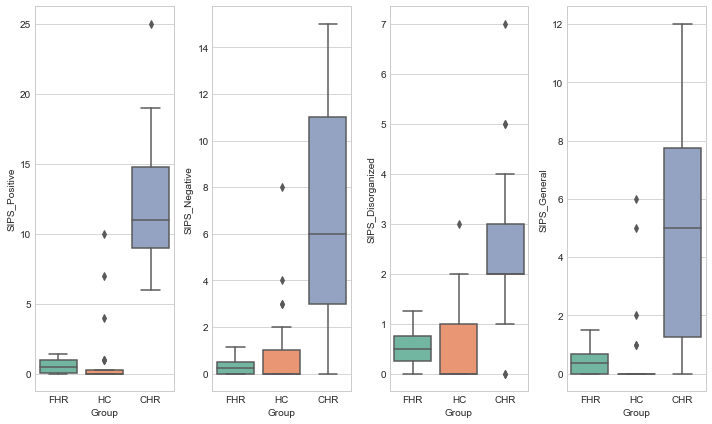

In [40]:
sips = raw[~(raw.Group == 'SZ')]

sips = sips[np.isfinite(sips ['SIPS_General'])]

sns.set_context(font_scale=2.5)
sns.set_palette("Set2")
sns.set_style("whitegrid")

fig = plt.figure(figsize=(10, 6))
si = fig.add_subplot(141)
sns.boxplot(y='SIPS_Positive', x='Group', data = sips)
si = fig.add_subplot(142)
sns.boxplot(y='SIPS_Negative', x='Group', data = sips)
si = fig.add_subplot(143)
sns.boxplot(y='SIPS_Disorganized', x='Group', data = sips)
si = fig.add_subplot(144)
sns.boxplot(y='SIPS_General', x='Group', data = sips)
fig.tight_layout()


# sns.plt.savefig(path2figs + 'SIPS_general.pdf')

print ('Between-group t-tests on SIPS General: Risk Groups')
misc.ttest_2s(sips[sips.Group == 'CHR']['SIPS_General'],sips[sips.Group == 'FHR']['SIPS_General'])

## Chapman

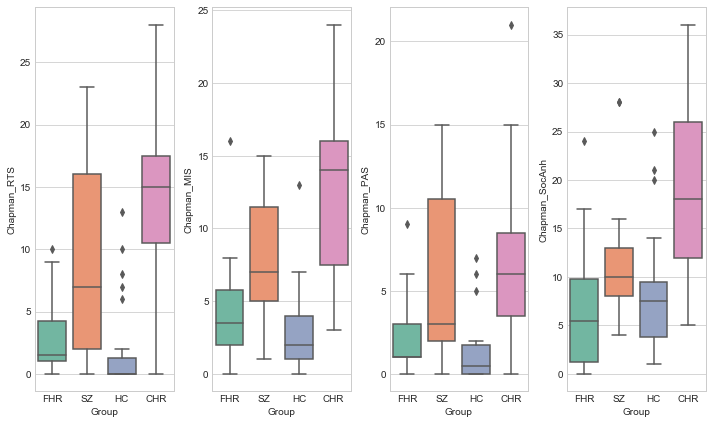

In [41]:
sns.set_context(font_scale=2.5)
sns.set_palette("Set2")
sns.set_style("whitegrid")

fig = plt.figure(figsize=(10, 6))
chap = fig.add_subplot(141)
sns.boxplot(y='Chapman_RTS', x='Group', data = raw)
chap = fig.add_subplot(142)
sns.boxplot(y='Chapman_MIS', x='Group', data = raw)
chap = fig.add_subplot(143)
sns.boxplot(y='Chapman_PAS', x='Group', data = raw)
chap = fig.add_subplot(144)
sns.boxplot(y='Chapman_SocAnh', x='Group', data = raw)
fig.tight_layout()


# sns.plt.savefig(path2figs + 'chapman.pdf')

## GFS

### Role

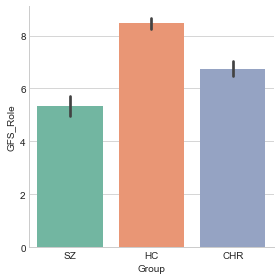

In [42]:
# no measures from FAME
gfs = raw[~(raw.Group == 'FHR')]

sns.set_context(font_scale=2.5)
sns.set_palette("Set2")
sns.set_style("whitegrid")

sns.factorplot(y='GFS_Role',x='Group',units='ID',ci=68,kind='bar',data=gfs)

### Social

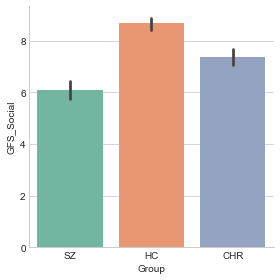

In [43]:
#No measures from FAME
sns.set_context(font_scale=2.5)
sns.set_palette("Set2")
sns.set_style("whitegrid")

sns.factorplot(y='GFS_Social',x='Group',units='ID',ci=68,kind='bar',data=gfs)

## SAS

### Social Leisure

SAS Social Leisure Mean
Group
CHR    62.772727
FHR    50.388889
HC     51.937500
SZ     63.680000
Name: SocAdjScale_SocialLeisure, dtype: float64


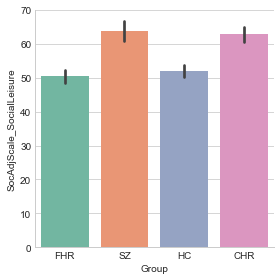

In [45]:
x = raw.groupby('Group')

print('SAS Social Leisure Mean')
print(x.SocAdjScale_SocialLeisure.mean())

sns.set_context(font_scale=2.5)
sns.set_palette("Set2")
sns.set_style("whitegrid")


# sns.plt.savefig(path2figs + 'SAS_SL.pdf')

sns.factorplot(y='SocAdjScale_SocialLeisure',x='Group',units='ID',ci=68,kind='bar',data=raw)

In [46]:
print ('ANOVA on Social Leisure x Group')
%R sl.aov <- aov(SocAdjScale_SocialLeisure ~ Group, data=raw)
%R print (summary(sl.aov))

ANOVA on Social Leisure x Group


            Df Sum Sq Mean Sq F value   Pr(>F)    
Group        3   3454  1151.3   8.675 3.91e-05 ***
Residuals   93  12341   132.7                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
13 observations deleted due to missingness


In [47]:
print ('Followup on SL x Group')
%R sl.lsm <- lsmeans(sl.aov, ~ Group, adjust='tukey')
%R print(sl.lsm)
%R print(pairs(sl.lsm))

Followup on SL x Group


 Group   lsmean       SE df lower.CL upper.CL
 CHR   62.77273 2.456011 93 57.89558 67.64988
 FHR   50.38889 2.715223 93 44.99699 55.78078
 HC    51.93750 2.036417 93 47.89358 55.98142
 SZ    63.68000 2.303943 93 59.10483 68.25517

Confidence level used: 0.95 


 contrast     estimate       SE df t.ratio p.value
 CHR - FHR  12.3838384 3.661206 93   3.382  0.0057
 CHR - HC   10.8352273 3.190452 93   3.396  0.0055
 CHR - SZ   -0.9072727 3.367513 93  -0.269  0.9931
 FHR - HC   -1.5486111 3.394029 93  -0.456  0.9682
 FHR - SZ  -13.2911111 3.560981 93  -3.732  0.0018
 HC - SZ   -11.7425000 3.074922 93  -3.819  0.0014

P value adjustment: tukey method for comparing a family of 4 estimates 


### Work

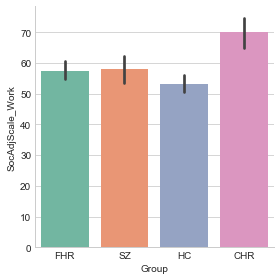

In [48]:
sns.set_context(font_scale=2.5)
sns.set_palette("Set2")
sns.set_style("whitegrid")

sns.factorplot(y='SocAdjScale_Work',x='Group',units='ID',ci=68,kind='bar',data=raw)

In [49]:
print ('ANOVA on Work x Group')
%R wk.aov <- aov(SocAdjScale_Work ~ Group, data=raw)
%R print (summary(wk.aov))

ANOVA on Work x Group


            Df Sum Sq Mean Sq F value Pr(>F)  
Group        3   3901  1300.4   3.342 0.0226 *
Residuals   93  36185   389.1                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
13 observations deleted due to missingness


In [50]:
print ('Followup on Work x Group')
%R wk.lsm <- lsmeans(wk.aov, ~ Group, adjust='tukey')
%R print(wk.lsm)
%R print(pairs(wk.lsm))

Followup on Work x Group


 Group   lsmean       SE df lower.CL upper.CL
 CHR   70.00000 4.112984 93 61.83243 78.16757
 FHR   57.50000 4.649270 93 48.26747 66.73253
 HC    53.16129 3.542747 93 46.12610 60.19648
 SZ    58.00000 3.945036 93 50.16594 65.83406

Confidence level used: 0.95 


 contrast  estimate       SE df t.ratio p.value
 CHR - FHR 12.50000 6.207443 93   2.014  0.1904
 CHR - HC  16.83871 5.428416 93   3.102  0.0134
 CHR - SZ  12.00000 5.699118 93   2.106  0.1589
 FHR - HC   4.33871 5.845234 93   0.742  0.8797
 FHR - SZ  -0.50000 6.097460 93  -0.082  0.9998
 HC - SZ   -4.83871 5.302298 93  -0.913  0.7982

P value adjustment: tukey method for comparing a family of 4 estimates 


## IRI and SAS: visualizing the relationship

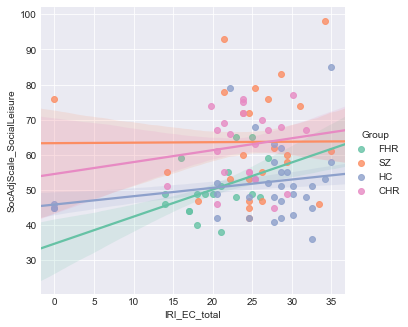

In [55]:
sns.set_context(font_scale=2.5)
sns.set_palette("Set2")
sns.set_style("darkgrid")

g = sns.lmplot(y='SocAdjScale_SocialLeisure',x='IRI_EC_total',hue='Group',
           units='ID',ci=68,data=raw)
plt.subplots_adjust(top=0.9)
# sns.suptitle('Social Leisure as a function of Empathic Concern', fontsize=14)


# sns.plt.savefig(path2figs + 'SASxIRI_EC.pdf')

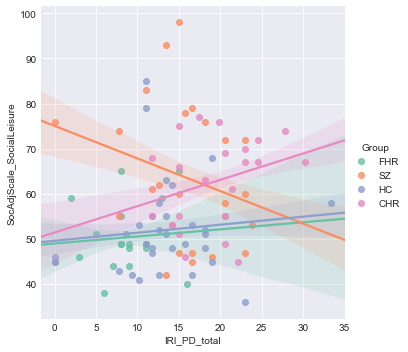

In [57]:
sns.lmplot(y='SocAdjScale_SocialLeisure',x='IRI_PD_total',hue='Group',
           units='ID',ci=68,data=raw)
# sns.plt.ylim(30,100)
# plt.subplots_adjust(top=0.9)
# sns.plt.suptitle('Social Leisure as a function of Personal Distress', fontsize=14)


# sns.plt.savefig(path2figs + 'SASxIRI_PD.pdf')

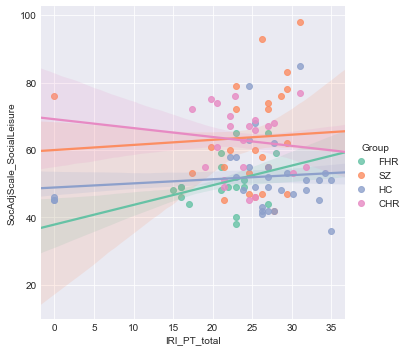

In [58]:
# %R iri_pt_sl <- aov(SocAdjScale_SocialLeisure ~ Group*IRI_PT_total,data=raw)
# %R print (summary(iri_pt_sl))

sns.lmplot(y='SocAdjScale_SocialLeisure',x='IRI_PT_total',hue='Group',
           units='ID',ci=68,data=raw)
# sns.plt.ylim(30,100)
# plt.subplots_adjust(top=0.9)
# sns.plt.suptitle('Social Leisure as a function of Perspective Taking', fontsize=14)


# sns.plt.savefig(path2figs + 'SASxIRI_PT.pdf')

                   Df Sum Sq Mean Sq F value   Pr(>F)    
Group               3   3454  1151.3   9.165 2.39e-05 ***
IRI_FS_total        1     98    97.6   0.777   0.3804    
Group:IRI_FS_total  3   1064   354.8   2.825   0.0432 *  
Residuals          89  11179   125.6                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
13 observations deleted due to missingness


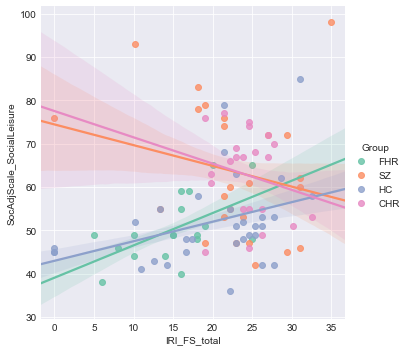

In [59]:
%R iri_fs_sl <- aov(SocAdjScale_SocialLeisure ~ Group*IRI_FS_total,data=raw)
%R print (summary(iri_fs_sl))

sns.lmplot(y='SocAdjScale_SocialLeisure',x='IRI_FS_total',hue='Group',
           units='ID',ci=68,data=raw)
# sns.plt.ylim(30,100)
# plt.subplots_adjust(top=0.9)
# sns.plt.suptitle('Social Leisure as a function of Fantasy', fontsize=14)


# sns.plt.savefig(path2figs + 'SASxIRI_FS.pdf')

### There are clear differences in prodromal psychotic sympoms between high risk groups, as shown in the SIPS scores. And though the trends don't always go in the same direction, the pattern on the SAS_SL ~ IRI plots are close and clearly group into into CHR/SZ and FHR/HC (other than personal distress where SZ does it's own thing). We also see a similar pattern in SAS_SL in the post-hoc tests above, where there are differences between HC and CHR, HC and SZ, but not CHR and SZ, as well as differences between FHR and CHR, FHR and SZ, but not FHR and HC.

### Extending this a bit further into the clinical direction, at least some subjects in both the FHR and CHR group have DSM diagnoses, and at least some FHR participants were experiencing depressive or anxious symptoms at time of testing (check on whether we have that info for CHR). Taken with the pattern of grouping above, this could mean that having symptoms on the psychotic spectrum, regardless of experiencing other clinical symptoms/meeting clinical diagnosis, would put you at risk for social deficits above and beyond other DSM diagnoses. 

### ***UPDATE: No clinical measures other than SIPS on FHR group to test hypothesis.

* Need to remove N1 on SIPS from negative symptoms if statistically testing (measures social functioning)

In [69]:
x = raw[['Group','IRI_EC_total','IRI_FS_total','IRI_PD_total','SocAdjScale_SocialLeisure']].copy()
x = x[np.isfinite(x['IRI_EC_total'])]
x = x[np.isfinite(x['IRI_FS_total'])]
x = x[np.isfinite(x['IRI_PD_total'])]
x = x[np.isfinite(x['SocAdjScale_SocialLeisure'])]

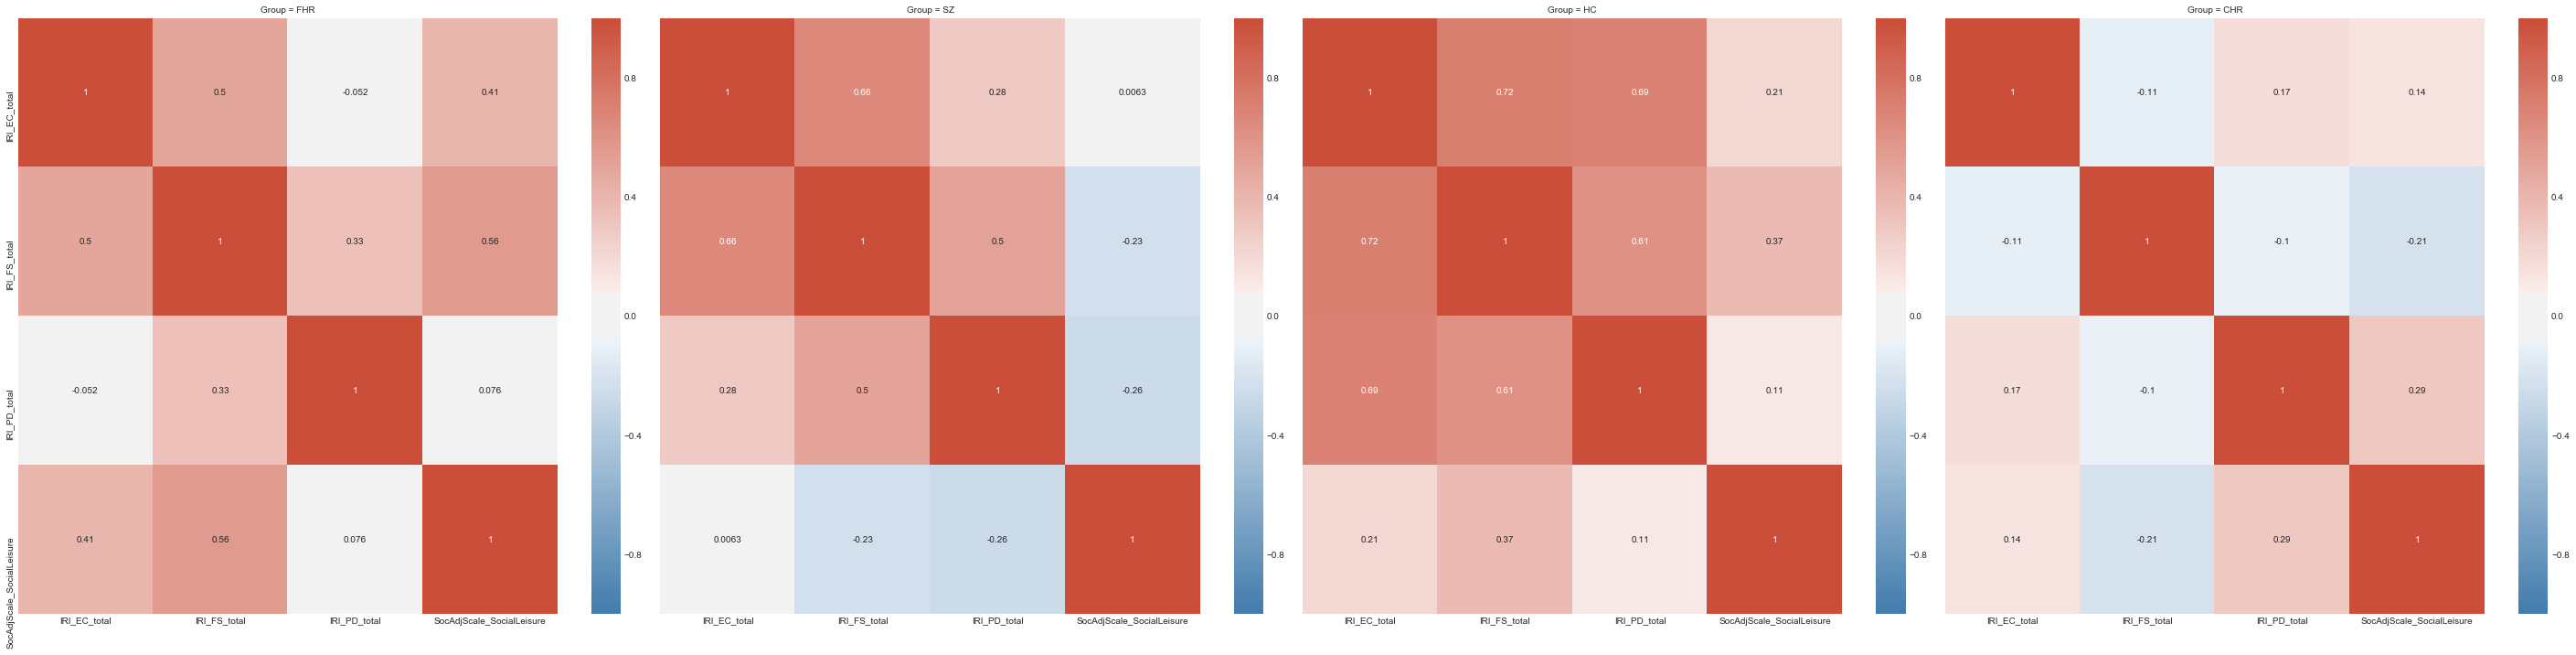

In [122]:
g = sns.FacetGrid(x, col = 'Group', size=10)
g.map_dataframe(lambda data, color: sns.heatmap(data.corr(), annot=True, linewidths=0, vmin=-1, vmax=1,
                                                cmap = sns.diverging_palette(243, 17, sep=20, as_cmap=True)))

plt.savefig("corr.pdf".format(g))

## Linear Models: SAS and IRI

The linear regression plots above were used as exploratory measures to visualize the relationship bewteen SAS_SL and the significant IRI subscales. As the plots suggest a linear relationship, below we are taking this a step further to fit a linear regression model to the items of interest.

%R modelname = linearmodel(dependent variable ~ explanatory variable, dataset)

Since we suspect that group plays a part in explaining this relationship, we add Group in to see if this improves the model i.e. better explains the variance. We find that group improves the models for each subscale below.

### Fantasy

In [60]:
%R lm1 = lm(SocAdjScale_SocialLeisure ~ IRI_FS_total, data = raw)
%R print (summary(lm1))


Call:
lm(formula = SocAdjScale_SocialLeisure ~ IRI_FS_total, data = raw)

Residuals:
    Min      1Q  Median      3Q     Max 
-21.757  -9.430  -3.550   8.155  40.219 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   48.5503     3.7638  12.899   <2e-16 ***
IRI_FS_total   0.4147     0.1712   2.423   0.0173 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 12.51 on 95 degrees of freedom
  (13 observations deleted due to missingness)
Multiple R-squared:  0.05819,	Adjusted R-squared:  0.04828 
F-statistic:  5.87 on 1 and 95 DF,  p-value: 0.0173



In [121]:
%R lm2 = lm(SocAdjScale_SocialLeisure ~ IRI_FS_total + Group, data = raw)
%R print (summary(lm2))


Call:
lm(formula = SocAdjScale_SocialLeisure ~ IRI_FS_total + Group, 
    data = raw)

Residuals:
    Min      1Q  Median      3Q     Max 
-22.108  -7.691  -1.762   6.712  32.461 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    59.145      4.899  12.074  < 2e-16 ***
IRI_FS_total    0.149      0.174   0.856  0.39403    
GroupFHR      -11.016      3.999  -2.755  0.00708 ** 
GroupHC       -10.168      3.289  -3.092  0.00263 ** 
GroupSZ         1.178      3.387   0.348  0.72877    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 11.54 on 92 degrees of freedom
  (13 observations deleted due to missingness)
Multiple R-squared:  0.2248,	Adjusted R-squared:  0.1911 
F-statistic: 6.671 on 4 and 92 DF,  p-value: 9.263e-05



In [62]:
%R print (anova(lm1, lm2))

Analysis of Variance Table

Model 1: SocAdjScale_SocialLeisure ~ IRI_FS_total
Model 2: SocAdjScale_SocialLeisure ~ IRI_FS_total + Group
  Res.Df   RSS Df Sum of Sq      F    Pr(>F)    
1     95 14876                                  
2     92 12244  3    2632.2 6.5928 0.0004377 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### Personal Distress

In [63]:
%R lm3 = lm(SocAdjScale_SocialLeisure ~ IRI_PD_total, data = raw)
%R print (summary(lm3))


Call:
lm(formula = SocAdjScale_SocialLeisure ~ IRI_PD_total, data = raw)

Residuals:
    Min      1Q  Median      3Q     Max 
-24.912  -8.265  -4.031   7.350  40.616 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   50.7684     3.1319  16.210   <2e-16 ***
IRI_PD_total   0.4410     0.1982   2.226   0.0284 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 12.57 on 95 degrees of freedom
  (13 observations deleted due to missingness)
Multiple R-squared:  0.04956,	Adjusted R-squared:  0.03956 
F-statistic: 4.954 on 1 and 95 DF,  p-value: 0.0284



In [64]:
%R lm4 = lm(SocAdjScale_SocialLeisure ~ IRI_PD_total + Group, data = raw)
%R print (summary(lm4))


Call:
lm(formula = SocAdjScale_SocialLeisure ~ IRI_PD_total + Group, 
    data = raw)

Residuals:
    Min      1Q  Median      3Q     Max 
-21.653  -7.722  -1.414   7.187  34.329 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   62.55152    4.91444  12.728  < 2e-16 ***
IRI_PD_total   0.01138    0.21861   0.052  0.95859    
GroupFHR     -12.26317    4.35002  -2.819  0.00590 ** 
GroupHC      -10.76304    3.49456  -3.080  0.00273 ** 
GroupSZ        0.94893    3.47899   0.273  0.78565    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 11.58 on 92 degrees of freedom
  (13 observations deleted due to missingness)
Multiple R-squared:  0.2187,	Adjusted R-squared:  0.1847 
F-statistic: 6.438 on 4 and 92 DF,  p-value: 0.0001299



In [65]:
%R print (anova(lm3, lm4))

Analysis of Variance Table

Model 1: SocAdjScale_SocialLeisure ~ IRI_PD_total
Model 2: SocAdjScale_SocialLeisure ~ IRI_PD_total + Group
  Res.Df   RSS Df Sum of Sq     F   Pr(>F)    
1     95 15012                                
2     92 12341  3    2671.3 6.638 0.000415 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### Empathic Concern

In [66]:
%R lm5 = lm(SocAdjScale_SocialLeisure ~ IRI_EC_total, data = raw)
%R print (summary(lm5))


Call:
lm(formula = SocAdjScale_SocialLeisure ~ IRI_EC_total, data = raw)

Residuals:
    Min      1Q  Median      3Q     Max 
-23.476  -9.266  -3.592   8.176  38.082 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   50.4719     4.6320  10.896   <2e-16 ***
IRI_EC_total   0.2762     0.1844   1.498    0.137    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 12.74 on 95 degrees of freedom
  (13 observations deleted due to missingness)
Multiple R-squared:  0.02307,	Adjusted R-squared:  0.01279 
F-statistic: 2.244 on 1 and 95 DF,  p-value: 0.1375



In [119]:
%R lm6 = lm(SocAdjScale_SocialLeisure ~ IRI_EC_total + Group, data = raw)
%R print (summary(lm6))


Call:
lm(formula = SocAdjScale_SocialLeisure ~ IRI_EC_total + Group, 
    data = raw)

Residuals:
    Min      1Q  Median      3Q     Max 
-21.622  -7.852  -1.349   6.847  32.281 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   57.4802     4.8426  11.870  < 2e-16 ***
IRI_EC_total   0.2184     0.1724   1.267 0.208465    
GroupFHR     -11.5315     3.7109  -3.107 0.002510 ** 
GroupHC      -11.1316     3.1887  -3.491 0.000741 ***
GroupSZ        0.7702     3.3584   0.229 0.819112    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 11.48 on 92 degrees of freedom
  (13 observations deleted due to missingness)
Multiple R-squared:  0.2321,	Adjusted R-squared:  0.1987 
F-statistic:  6.95 on 4 and 92 DF,  p-value: 6.201e-05



In [81]:
#IRI_EC can account for 23% of the variation in SAS_SL scores

%R sqrt(0.2321)

array([ 0.48176758])

In [68]:
%R print (anova(lm5, lm6))

Analysis of Variance Table

Model 1: SocAdjScale_SocialLeisure ~ IRI_EC_total
Model 2: SocAdjScale_SocialLeisure ~ IRI_EC_total + Group
  Res.Df   RSS Df Sum of Sq      F    Pr(>F)    
1     95 15431                                  
2     92 12130  3    3300.9 8.3453 5.756e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [86]:
raw.columns

Index([u'ID', u'Group', u'Gender', u'Age', u'Education', u'Ethnicity', u'IQ',
       u'DSMDisorder', u'DSMDisorderType', u'DSMcomorbidities',
       u'IRI_EC_total', u'IRI_FS_total', u'IRI_PD_total', u'IRI_PT_total',
       u'Chapman_MIS', u'Chapman_PAS', u'Chapman_PhAS', u'Chapman_RTS',
       u'Chapman_SocAnh', u'Medication', u'PANAS_NA', u'PANAS_PA',
       u'SIPS_Disorganized', u'SIPS_General', u'SIPS_Negative',
       u'SIPS_Positive', u'SocAdjScale_SocialLeisure', u'SocAdjScale_Work',
       u'GFS_Role', u'GFS_Social', u'Present_Clinical', u'sx_group'],
      dtype='object')

In [117]:
#Starred coefficients are predictors making a significant contribution to the model

%R lm7 = lm(SocAdjScale_SocialLeisure ~ SIPS_Negative + Group, data = raw)
%R print (summary(lm7))


Call:
lm(formula = SocAdjScale_SocialLeisure ~ SIPS_Negative + Group, 
    data = raw)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.2642  -4.3532  -0.2545   4.9989  14.8130 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    55.2909     2.7700  19.961  < 2e-16 ***
SIPS_Negative   0.9976     0.3004   3.321  0.00163 ** 
GroupFHR       -5.1040     3.2647  -1.563  0.12392    
GroupHC        -7.2899     3.2040  -2.275  0.02696 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.561 on 53 degrees of freedom
  (53 observations deleted due to missingness)
Multiple R-squared:  0.5034,	Adjusted R-squared:  0.4753 
F-statistic: 17.91 on 3 and 53 DF,  p-value: 3.731e-08



In [101]:
#standardized beta estimate
%R print (lm.beta(lm7))

SIPS_Negative      GroupFHR       GroupHC 
    0.4642110    -0.4117914    -3.3922750 


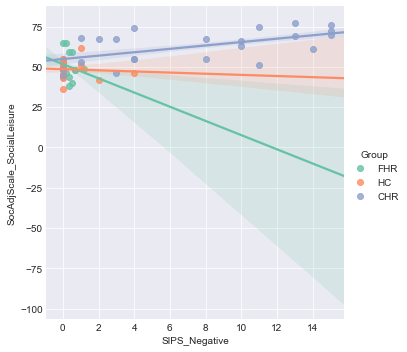

In [97]:
sns.lmplot(y='SocAdjScale_SocialLeisure',x='SIPS_Negative',hue='Group',
           units='ID',ci=68,data=sips)

In [114]:
%R lm8 = lm(SocAdjScale_SocialLeisure ~ SIPS_Positive + Group, data = raw)
%R print (summary(lm8))


Call:
lm(formula = SocAdjScale_SocialLeisure ~ SIPS_Positive + Group, 
    data = raw)

Residuals:
     Min       1Q   Median       3Q      Max 
-16.2457  -5.2609  -0.2609   5.5514  14.7043 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    55.7385     5.0578  11.020 2.53e-15 ***
SIPS_Positive   0.5507     0.3719   1.481    0.145    
GroupFHR       -5.5529     5.2622  -1.055    0.296    
GroupHC        -7.4776     5.3013  -1.411    0.164    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.144 on 53 degrees of freedom
  (53 observations deleted due to missingness)
Multiple R-squared:  0.4239,	Adjusted R-squared:  0.3913 
F-statistic:    13 on 3 and 53 DF,  p-value: 1.765e-06



In [113]:
%R lm9 = lm(SocAdjScale_SocialLeisure ~ Present_Clinical + Group, data = raw)
%R print (summary(lm9))


Call:
lm(formula = SocAdjScale_SocialLeisure ~ Present_Clinical + Group, 
    data = raw)

Residuals:
    Min      1Q  Median      3Q     Max 
-21.680  -6.938  -2.809   6.354  34.320 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)        58.276      3.332  17.491  < 2e-16 ***
Present_Clinical    6.773      4.301   1.575  0.11908    
GroupFHR          -12.402      4.317  -2.873  0.00514 ** 
GroupHC            -6.338      3.917  -1.618  0.10932    
GroupSZ            -1.368      4.764  -0.287  0.77462    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 11.65 on 85 degrees of freedom
  (20 observations deleted due to missingness)
Multiple R-squared:  0.2175,	Adjusted R-squared:  0.1806 
F-statistic: 5.905 on 4 and 85 DF,  p-value: 0.0003052

